<a href="https://colab.research.google.com/github/Piyush94-BA/Topic-Modelling/blob/main/Comcast_Telecom_Complaints_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing all relevant packages
!pip install pyspellchecker
!apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext
!pip install -U nltk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
libpoppler-cpp-dev is already the newest version (0.62.0-2ubuntu2.12).
python3-dev is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [2]:
#importing relevant libraries
import string
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker
from nltk.corpus import stopwords
import pdftotext
import nltk
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
data = pd.read_excel('JARVIS_Case 2_dataset.xlsx')

In [5]:
data.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,2015-04-22,15:53:50,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,2015-04-08 00:00:00,2015-08-04,10:22:56,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,2015-04-18,09:55:47,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,2015-05-07 00:00:00,2015-07-05,11:59:35,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,2015-05-26,13:25:26,Internet,Acworth,Georgia,30101,Solved,No


In [6]:
data = data.drop(['Ticket #', 'Date','Date_month_year','Time','Received Via','City','State','Zip code','Status','Filing on Behalf of Someone'], axis=1)

In [7]:
data = data.rename(columns={'Customer Complaint': 'Customer_Complaint'})

In [8]:
data.head()

,Customer_Complaint
0,Comcast Cable Internet Speeds
1,Payment disappear - service got disconnected
2,Speed and Service
3,Comcast Imposed a New Usage Cap of 300GB that ...
4,Comcast not working and no service to boot


In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only     the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if   is_noun_adj(pos)]
    return ' '.join(nouns_adj)
#if this code doesn't work on you, it's probably indentaion mistake coming from Medium writing format.

In [11]:
data_nouns_adj = pd.DataFrame(data.Customer_Complaint.apply(nouns_adj))
data_nouns_adj

,Customer_Complaint
0,Comcast Cable Internet Speeds
1,Payment service disconnected
2,Speed Service
3,Comcast New Usage Cap punishes
4,Comcast service
...,...
2219,Service Availability
2220,Comcast Monthly Billing Returned Modem
2221,complaint comcast
2222,unsatisfied Comcast customer


In [169]:
data.shape

(2224, 1)

In [12]:
#cleaning the text and returning a list of tokens
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL') #removing any links in the text
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_) #converting to lowercase
    return lda_tokens

In [13]:
#Lemmatization
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
#Removing Stopwords
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [16]:
#Preparing data for LDA
import random
text_data = []
for i in range(len(data_nouns_adj)) :
  #print(i)
  tokens = prepare_text_for_lda(data_nouns_adj.loc[i, "Customer_Complaint"])
  #if random.random() > .99:
  print(tokens)
  text_data.append(tokens)

['comcast', 'cable', 'internet', 'speed']
['payment', 'service', 'disconnect']
['speed', 'service']
['comcast', 'new', 'usage', 'cap', 'punish']
['comcast', 'service']
['isp', 'charge', 'arbitrary', 'data', 'limit', 'overage', 'fee']
['service', 'unreasonable', 'data', 'cap']
['comcast', 'troubleshoot', 'service']
['comcast', 'outage']
['comcast', 'price', 'available', 'ask']
['billing', 'service']
['yahoo', 'failure', 'restore', 'email', 'search', 'feature']
['comcast', 'violate', 'open', 'internet', 'rule', 'hbo', 'access', 'sony', 'console']
['internet', 'speed']
['internet', 'every', 'night']
['internet', 'complaint']
['internet', 'availability', 'speed']
['comcast', 'claim', 'equipment']
['horrible', 'internet', 'service']
['failure', 'services']
['internet', 'time', 'monopoly']
['horrible', 'cable', 'service', 'customer', 'service']
['speed']
['comcast', 'monopoly', 'bundling', 'practice']
['comcast']
['bait']
['comcast', 'customer', 'service']
['apartment', 'management', 'exclus

In [17]:
#Bag of words
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')


In [146]:
#LDA to find 5 topics in the data

import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.263*"comcast" + 0.076*"billing" + 0.068*"complaint" + 0.060*"xfinity"')
(1, '0.267*"internet" + 0.137*"comcast" + 0.091*"speed" + 0.080*"service"')
(2, '0.138*"service" + 0.124*"comcast" + 0.043*"billing" + 0.028*"price"')
(3, '0.151*"data" + 0.143*"comcast" + 0.134*"cap" + 0.065*"issue"')
(4, '0.087*"comcast" + 0.076*"bill" + 0.058*"service" + 0.056*"charge"')


In [21]:
#LDA to find 5 topics in the data

import gensim
NUM_TOPICS = 5
ldamodel1 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel1.save('model5.gensim')
topics = ldamodel1.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.051*"false" + 0.040*"deceptive" + 0.033*"advertising" + 0.030*"failure"')
(1, '0.178*"internet" + 0.129*"comcast" + 0.087*"speed" + 0.053*"issue"')
(2, '0.213*"comcast" + 0.145*"service" + 0.086*"data" + 0.076*"cap"')
(3, '0.167*"comcast" + 0.106*"billing" + 0.066*"complaint" + 0.060*"charge"')
(4, '0.110*"comcast" + 0.034*"problem" + 0.032*"price" + 0.029*"month"')


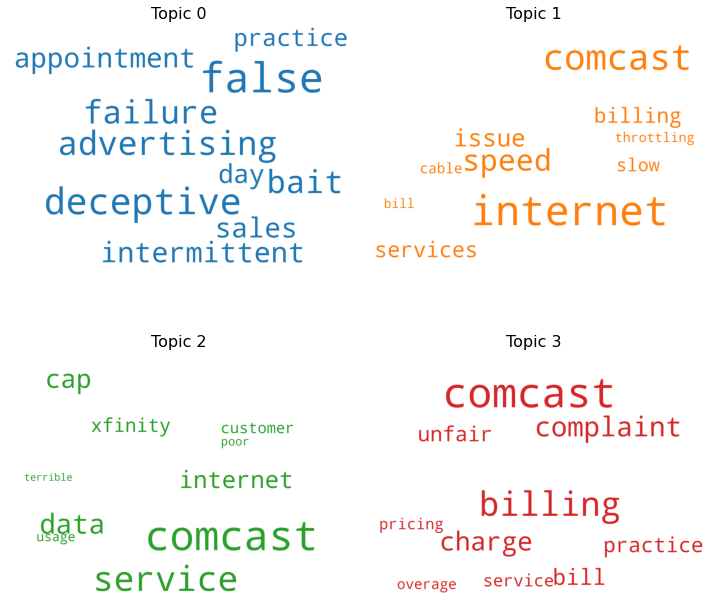

In [22]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=en_stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
!pip install pyLDAvis

In [155]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)

In [156]:
pyLDAvis.show(vis_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103097  0.140092       1        1  27.471334
3     -0.128441 -0.113807       2        1  25.747319
4     -0.098988 -0.183183       3        1  19.134226
2      0.010583  0.221442       4        1  17.156725
1      0.319943 -0.064545       5        1  10.490396, topic_info=         Term        Freq       Total Category  logprob  loglift
6     service  384.000000  384.000000  Default  30.0000  30.0000
2    internet  460.000000  460.000000  Default  29.0000  29.0000
13       data  207.000000  207.000000  Default  28.0000  28.0000
7         cap  184.000000  184.000000  Default  27.0000  27.0000
24    billing  226.000000  226.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
214      scam    6.314170    8.816809   Topic5  -4.7362   1.9208
123   account    6.673476   17.043671   Topic5  -4.6809   1.3171
45   services    8.999131   76.287886   Topic5  -4.3819   0.1173
141      poor    6.597568   37.424432   Topic5  -4.6923   0.5191
63    xfinity    7.237204   99.869254   Topic5  -4.5998  -0.3699

[228 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
31        3  0.961415       access
123       1  0.586728      account
123       5  0.410710      account
149       2  0.982607  advertising
225       2  0.891349    agreement
...     ...       ...          ...
63        4  0.140183      xfinity
63        5  0.070092      xfinity
83        4  0.930933         year
271       5  0.976416        years
920       3  0.841954    ypsilanti

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])